In [1]:
import torch
import torch.nn as nn
import os
import mlp.data_providers as data_providers
import numpy as np
from storage_utils import load_statistics
from collections import OrderedDict
from model_architectures import ConvolutionalNetwork
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
train_data = data_providers.EMNISTDataProvider('train', batch_size=100000)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=15800)
test_data = data_providers.EMNISTDataProvider('test', batch_size=1)

KeysView(<numpy.lib.npyio.NpzFile object at 0x11ee4f240>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x11ee4f240>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x11ee4f1d0>)


In [3]:
model_names = ['3', '5', '7', '9', '11']
models = OrderedDict()
stats = OrderedDict()

batch_size = 128
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_type = 'max_pooling'
num_filters = 128
num_layers = 4
kernel_sizes = [3,5,7,9,11]
num_epochs = 50
weight_decay_coefficient = 1e-5
seed = 7112018
use_gpu = False

In [4]:
def rename_dict_key(old_dict):
    new_dict = OrderedDict()
    for key in old_dict.keys():
        new_dict[key[6:]] = old_dict[key]
    return new_dict

In [5]:
# load summary stats
for model_name, kernel_size in zip(model_names, kernel_sizes):
    experiment_log_dir = './outputs/kernel_size/' + model_name + '/result_outputs/'
    summary = load_statistics(experiment_log_dir, 'summary.csv')
    stats[model_name] = summary

In [6]:
# training accuracy plot
plt.figure(figsize=(8,8), dpi=1000)
colors = ['r', 'g', 'b', 'm', 'y']

for model_name, c in zip(model_names,  colors):
    statistics = stats[model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float') * 100, label=model_name+'_train', c=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float') * 100, label=model_name+'_valid', c=c, linestyle='--')
    
plt.legend(loc=4, fontsize=14)
plt.ylim((60, 100))
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.savefig('./plots/2_1_kernel_size.pdf', dpi=1000)
# plt.title('Accuracy', fontsize=20)

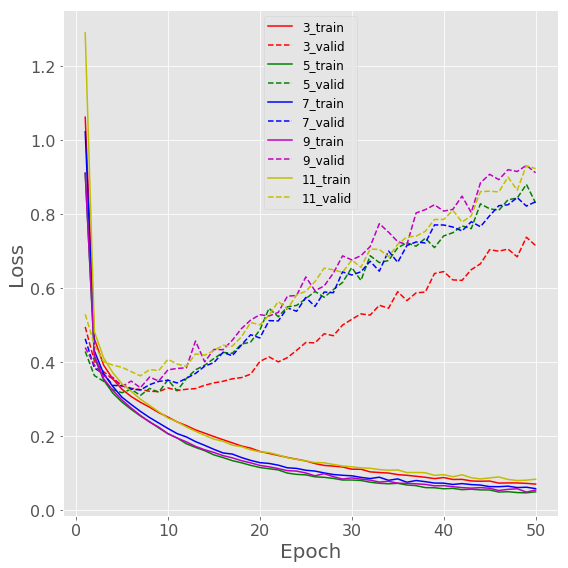

In [8]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm', 'y']

for model_name, c in zip(model_names,  colors):
    statistics = stats[model_name]
    train_loss = statistics['train_loss']
    valid_loss = statistics['val_loss\n']
    plt.plot(np.arange(1, len(train_loss)+1), np.array(train_loss, dtype='float'), label=model_name+'_train', c=c)
    plt.plot(np.arange(1, len(valid_loss)+1), np.array(valid_loss, dtype='float'), label=model_name+'_valid', c=c, linestyle='--')
    
plt.legend(loc=0, fontsize=12)
# plt.ylim((50, 100))
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
# plt.title('Loss', fontsize=20)


In [17]:
def evaluation(dataset, model):
    accs = []
    for inputs, targets in dataset:
        inputs_tensor = torch.Tensor(inputs).float().to(device='cpu')
        prediction = model(inputs_tensor)
        prediction = prediction.detach().numpy()
        acc = prediction.argmax(-1) == targets.argmax(-1)
        accs.append(acc)
    accs = np.array(accs)
    return accs.astype(int)

In [18]:
accs = evaluation(test_data, conv_model)

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

best_idxs = []
best_valid_accs = []
best_train_accs = []
num_params = []
# load best models
for model_name, kernel_size in zip(model_names, kernel_sizes):
    print(kernel_size)
    conv_model = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type,
        num_output_classes=47, 
        num_filters=num_filters, 
        num_layers=num_layers, 
        kernel_size=kernel_size,
        use_bias=True)
    
    model_save_dir = './outputs/kernel_size/' + model_name + '/saved_models/'
    path = os.path.join(model_save_dir, "{}_{}".format("train_model", 49))
    
    device = torch.device('cpu')
    state = torch.load(path, map_location=device)
    best_val_model_idx, best_val_model_acc = state['best_val_model_idx'], state['best_val_model_acc']
    best_idxs.append(best_val_model_idx)
    
    best_valid_accs.append(best_val_model_acc)
    best_train_acc = stats[model_name]['train_acc'][best_val_model_idx]
    best_train_accs.append(best_train_acc)
    
    path = os.path.join(model_save_dir, "{}_{}".format("train_model", best_val_model_idx))
    state = torch.load(path, map_location=device)
    new_state = rename_dict_key(state['network'])
    conv_model.load_state_dict(state_dict=new_state)
    conv_model.eval()
    
    models[model_name] = conv_model
    num = count_parameters(conv_model)
    num_params.append(num)

3
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 128, 28, 28])
torch.Size([128, 128, 15, 15])
torch.Size([128, 128, 15, 15])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 5, 5])
torch.Size([128, 128, 5, 5])
torch.Size([128, 128, 3, 3])
shape before final linear layer torch.Size([128, 128, 2, 2])
Block is built, output volume is torch.Size([128, 47])
5
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 128, 28, 28])
torch.Size([128, 128, 15, 15])
torch.Size([128, 128, 15, 15])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 5, 5])
torch.Size([128, 128, 5, 5])
torch.Size([128, 128, 3, 3])
shape before final linear layer torch.Size([128, 128, 2, 2])
Block is built, output volume is torch.Size([128, 47])
7
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 128, 28, 28])
torch.Size([128

In [23]:
num_params

[468143, 1256623, 2439343, 4016303, 5987503]

In [24]:
best_train_accs

['0.9129521446862996',
 '0.9123019366197183',
 '0.9161231594110115',
 '0.9097211107554417',
 '0.8967369558258643']

In [25]:
best_valid_accs

[0.8923399390243902,
 0.8892276422764228,
 0.8873856707317073,
 0.8828125,
 0.8736026422764228]

In [31]:
import math
convnet =   [[3, 1, 1],[3 ,2, 1], [3, 1, 1], [3 ,2, 1], [3, 1, 1], [3 ,2, 1], [3, 1, 1],[3 ,2, 1]]
layer_names = ['conv1','conv2','conv3','conv4', 'conv5', 'conv6', 'conv7', 'conv8']
imsize = 28

def outFromIn(conv, layerIn):
  n_in = layerIn[0]
  j_in = layerIn[1]
  r_in = layerIn[2]
  start_in = layerIn[3]
  k = conv[0]
  s = conv[1]
  p = conv[2]
  
  n_out = math.floor((n_in - k + 2*p)/s) + 1
  actualP = (n_out-1)*s - n_in + k 
  pR = math.ceil(actualP/2)
  pL = math.floor(actualP/2)
  
  j_out = j_in * s
  r_out = r_in + (k - 1)*j_in
  start_out = start_in + ((k-1)/2 - pL)*j_in
  return n_out, j_out, r_out, start_out
  
def printLayer(layer, layer_name):
  print(layer_name + ":")
  print("\t n features: %s \n \t jump: %s \n \t receptive size: %s \t start: %s " % (layer[0], layer[1], layer[2], layer[3]))

In [32]:
layerInfos = []
# first layer is the data layer (image) with n_0 = image size; j_0 = 1; r_0 = 1; and start_0 = 0.5
print ("-------Net summary------")
currentLayer = [imsize, 1, 1, 0.5]
printLayer(currentLayer, "input image")
for i in range(len(convnet)):
    currentLayer = outFromIn(convnet[i], currentLayer)
    layerInfos.append(currentLayer)
    printLayer(currentLayer, layer_names[i])
print ("------------------------")
layer_name = raw_input ("Layer name where the feature in: ")
layer_idx = layer_names.index(layer_name)
idx_x = int(raw_input ("index of the feature in x dimension (from 0)"))
idx_y = int(raw_input ("index of the feature in y dimension (from 0)"))

n = layerInfos[layer_idx][0]
j = layerInfos[layer_idx][1]
r = layerInfos[layer_idx][2]
start = layerInfos[layer_idx][3]
assert(idx_x < n)
assert(idx_y < n)

print ("receptive field: (%s, %s)" % (r, r))
print ("center: (%s, %s)" % (start+idx_x*j, start+idx_y*j))

-------Net summary------
input image:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 1 	 start: 0.5 
conv1:
	 n features: 28 
 	 jump: 1 
 	 receptive size: 3 	 start: 0.5 
conv2:
	 n features: 14 
 	 jump: 2 
 	 receptive size: 5 	 start: 1.5 
conv3:
	 n features: 14 
 	 jump: 2 
 	 receptive size: 9 	 start: 1.5 
conv4:
	 n features: 7 
 	 jump: 4 
 	 receptive size: 13 	 start: 3.5 
conv5:
	 n features: 7 
 	 jump: 4 
 	 receptive size: 21 	 start: 3.5 
conv6:
	 n features: 4 
 	 jump: 8 
 	 receptive size: 29 	 start: 3.5 
conv7:
	 n features: 4 
 	 jump: 8 
 	 receptive size: 45 	 start: 3.5 
conv8:
	 n features: 2 
 	 jump: 16 
 	 receptive size: 61 	 start: 11.5 
------------------------


NameError: name 'raw_input' is not defined